In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
Ravdess = "C:/Users/Алексей/Desktop/учёба/python/speech-emotion-recognition-ravdess-data"
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + '/' + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + '/' + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,C:/Users/Алексей/Desktop/учёба/python/speech-e...
1,neutral,C:/Users/Алексей/Desktop/учёба/python/speech-e...
2,neutral,C:/Users/Алексей/Desktop/учёба/python/speech-e...
3,neutral,C:/Users/Алексей/Desktop/учёба/python/speech-e...
4,calm,C:/Users/Алексей/Desktop/учёба/python/speech-e...


In [3]:
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,C:/Users/Алексей/Desktop/учёба/python/speech-e...
1,neutral,C:/Users/Алексей/Desktop/учёба/python/speech-e...
2,neutral,C:/Users/Алексей/Desktop/учёба/python/speech-e...
3,neutral,C:/Users/Алексей/Desktop/учёба/python/speech-e...
4,calm,C:/Users/Алексей/Desktop/учёба/python/speech-e...


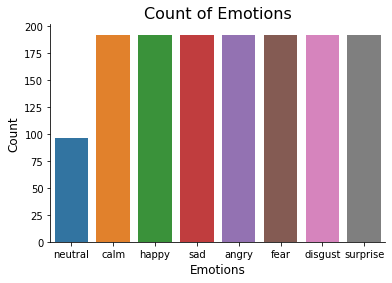

In [4]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [5]:
data_path.Path[0]

'C:/Users/Алексей/Desktop/учёба/python/speech-emotion-recognition-ravdess-data/Actor_01/03-01-01-01-01-01-01.wav'

In [6]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

In [7]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [8]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [9]:
len(X), len(Y), data_path.Path.shape


(4320, 4320, (1440,))

In [10]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.237707,0.659504,0.688300,0.660306,0.668153,0.691578,0.679806,0.700728,0.743931,0.777429,...,1.971535e-16,1.694119e-16,1.561859e-16,1.566727e-16,1.521193e-16,1.325442e-16,1.309995e-16,1.341276e-16,1.188672e-16,neutral
1,0.333898,0.783868,0.841631,0.822366,0.814667,0.835120,0.766888,0.681946,0.710950,0.754929,...,1.209044e-04,1.149589e-04,1.146029e-04,1.142487e-04,1.129702e-04,1.172308e-04,1.188909e-04,1.250954e-04,1.202250e-04,neutral
2,0.166967,0.578606,0.608995,0.669059,0.597341,0.606837,0.673561,0.681284,0.704720,0.715759,...,8.504842e-13,7.684326e-13,5.920987e-13,5.803375e-13,6.579538e-13,5.743235e-13,4.853721e-13,5.919732e-13,5.719862e-13,neutral
3,0.207284,0.649996,0.689978,0.661347,0.645627,0.683498,0.684929,0.679601,0.732510,0.756296,...,9.362395e-17,1.017879e-16,8.988049e-17,9.321180e-17,9.068552e-17,9.977286e-17,8.490875e-17,8.585167e-17,9.594946e-17,neutral
4,0.335250,0.800527,0.841194,0.817580,0.803836,0.809716,0.715835,0.670987,0.716285,0.753328,...,1.794014e-04,1.771612e-04,1.799059e-04,1.847258e-04,1.745911e-04,1.820783e-04,1.796495e-04,1.794041e-04,1.782596e-04,neutral


In [11]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
Y.shape

(4320,)

In [12]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [13]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [14]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [15]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [16]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

In [17]:
model=Sequential()
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(320, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 162, 128)          768       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 81, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 81, 32)            20512     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 41, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 41, 320)           51520     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 21, 320)           0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 320)           0

In [18]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 [==============================] - 7s 118ms/step - loss: 2.0429 - accuracy: 0.1581 - val_loss: 1.9834 - val_accuracy: 0.1750
Epoch 2/50
51/51 [==============================] - 5s 101ms/step - loss: 1.9898 - accuracy: 0.1818 - val_loss: 1.8828 - val_accuracy: 0.3056
Epoch 3/50
51/51 [==============================] - 5s 101ms/step - loss: 1.9037 - accuracy: 0.2587 - val_loss: 1.7899 - val_accuracy: 0.3306
Epoch 4/50
51/51 [==============================] - 5s 98ms/step - loss: 1.8512 - accuracy: 0.2777 - val_loss: 1.6850 - val_accuracy: 0.3463
Epoch 5/50
51/51 [==============================] - 5s 98ms/step - loss: 1.7590 - accuracy: 0.3321 - val_loss: 1.5991 - val_accuracy: 0.4009
Epoch 6/50
51/51 [==============================] - 5s 99ms/step - loss: 1.6920 - accuracy: 0.3407 - val_loss: 1.6072 - val_accuracy: 0.3880
Epoch 7/50
51/51 [==============================] - 5s 100ms/step - loss: 1.6833 - accuracy: 0.3605 - val_loss: 1.5422 - val_accuracy: 0.4167
Epoch 8/5

34/34 [==============================] - 0s 11ms/step - loss: 1.2717 - accuracy: 0.6037
Accuracy of our model on test data :  60.370367765426636 %


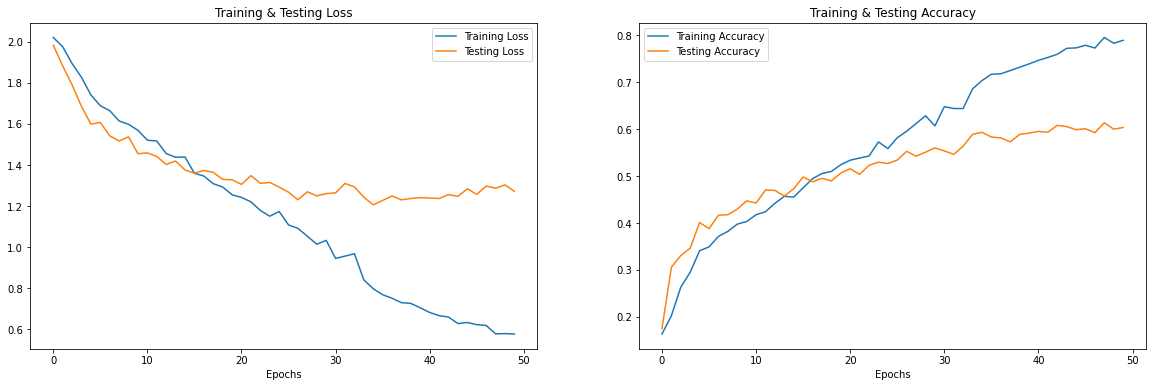

In [19]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [20]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [21]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,fear,fear
1,angry,angry
2,fear,fear
3,neutral,calm
4,angry,angry
5,surprise,surprise
6,sad,fear
7,fear,happy
8,fear,fear
9,calm,sad


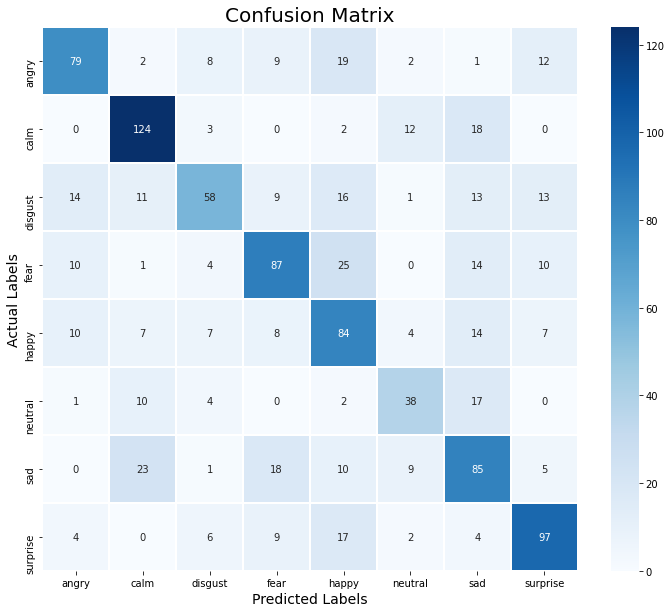

In [22]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [23]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       angry       0.67      0.60      0.63       132
        calm       0.70      0.78      0.74       159
     disgust       0.64      0.43      0.51       135
        fear       0.62      0.58      0.60       151
       happy       0.48      0.60      0.53       141
     neutral       0.56      0.53      0.54        72
         sad       0.51      0.56      0.54       151
    surprise       0.67      0.70      0.69       139

    accuracy                           0.60      1080
   macro avg       0.61      0.60      0.60      1080
weighted avg       0.61      0.60      0.60      1080



In [24]:
model.save('models/keras.h5')

In [25]:
new_model = tf.keras.models.load_model('models/keras.h5')

In [26]:
pred_test = new_model.predict(x_test)
pred_test
y_pred = encoder.inverse_transform(pred_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,fear,fear
1,angry,angry
2,fear,fear
3,neutral,calm
4,angry,angry
5,surprise,surprise
6,sad,fear
7,fear,happy
8,fear,fear
9,calm,sad


In [27]:
y_pred

array([['fear'],
       ['angry'],
       ['fear'],
       ...,
       ['surprise'],
       ['calm'],
       ['calm']], dtype=object)